![img](pictures/banner.png)

<img align='right' style='max-width: 200px; height: auto' src='pictures/hsg_logo.png'>



## Lab 03 - "Deep Learning - Image Segmentation"

Machine Learning, University of St. Gallen, Fall Term 2022

From an **image processing** point of view, image segmentation consists of clustering groups of pixels according to a predefined measure of similarity. The use of such techniques (e.g., image thresholding) generally does not take semantic content into account: an object of multiple colors would be segmented into different parts, instead of just one as desired. 


<img align='center' src='pictures/image_thresholding.png'>

The **deep learning approach** redefines semantic segmentation as pixel classification and reuses trained networks for image classification by making them fully convolutional.

In this lab, we will implement and train a **deep segmentation model** using the *PyTorch* library. The network will be trained on a **remote sensing** dataset (a dataset consisting of satellite images) for flood detection, i.e. segmenting flooded areas (water) in an image.

After today's lab, you should be able to:

- Understand the intuition behind image segmentation models.

- Understand the nature of satellite images and know how to load and use them.

- Train and evaluate with appropriate performance metrics a deep segmentation model.

- Train a multimodal network using different modality fusion techniques.

As always, don't hesitate to ask all your questions either during the lab, post them in our CANVAS (StudyNet) forum (https://learning.unisg.ch), or send us an email (using the course email).

## Content

1. [Introduction](#introduction)
2. [Performance Measure](#performance-measure)
3. [Dataset](#dataset)
4. [Model Creation](#model)
5. [Training and Validation](#train-val)
6. [Evaluation](#evaluation)
7. [Modality Fusion](#multimodal_fusion)
8. [Exercice](#exercice)
9. [Conclusion](#conclusion)

<a id='introduction'></a>
## 1. Introduction

#### A. Classification vs segmentation data

Some of the main tasks in computer vision include:
* Classification
* Object detection
* *Semantic and/or instance segmentation*

Many other tasks also exist, such as:
* Super-resolution
* Image Synthesis
* Image Captioning
* etc.

Here is a figure illustrating the difference between target data for a semantic segmentation task and those for other main computer vision tasks.

![Computer vision tasks](pictures/cv-tasks.png)

#### B. Classification vs segmentation models

By transforming networks normally used for image classification into fully convolutional ones, the deep learning approach for semantic segmentation is nothing more than pixel classification. Here is an illustrated example on how to use a classification model (e.g. VGG16) for a semantic segmentation task. 

This is what a VGG16 model looks like for classification. Initially, you have as input a 3d tensor (an RGB image) of spatial size 192 x 128, in other words your input tensor has in total a shape of 192x128x3. You then pass this input through multiple layers of convolutions, relu, and maxpooling. At the end, you flatten the representation, and pass it to the fully connected (linear) layer, followed by an activation function which will take care of producing probabilities associated with each of the classes.

![Classification Model](pictures/classification_model.png)



To adapt this model for a segmentation task, it needs to be able to output predictions for every pixel in the input image. To do this, we remove the last block of linear layers, and we replace it by a " fully-connected convolution " or a " pointwise convolution ", which means in other words a 1x1 convolution. This will reduce the channel dimensions from 512d to cd, c being the number of classes. Since VGG16 has 5 max-pooling with 2 × 2 kernels, the output is $\frac{1}{2^5}$ = $\frac{1}{32}$ the size of the input (here we went from 192x128 to 4x6). We need to re-expand it to its original size using for example linear interpolation. 

![Segmentation Model](pictures/segmentation_model.png)

Although this method works quite ok and produces qualitatively reasonable results, its main weakness comes from the fact that the signal entering the last layer is too coarse: the interpolation is done from 1/32 (4x6) to 1 (192x128) without any additional information.

A solution to this problem has been proposed by several works, and it is now the standard way to create a segmentation model (we will see it in the [next section](#model)).




The intuition behind this is that through maximum pooling and convolution, you gradually scale down to 1/32 of the original size, going through various resolutions in between, i.e. 1/2, 1/4, 1/8, 1/16. Instead of upscaling all at once, we can do it progressively using interpolation and convoltuion, passing by all these different resolutions and adding maps coming from the downsampling path when we reach the same resolution during upscaling. 

![Segmentation Model](pictures/segmentation_model_residual.png)


<a id='performance-measure'></a>
## 2. Performance Measure

How do we know if the model we implemented and trained is working well? Well, here is a list of the most used performance measures to evaluate a segmentation model.

* **Pixel Accuracy**: Let $A$ be the ground truth map and $B$ the predicted one. Pixel accuracy is the percentage of pixels in the predicted map that are identical to those in the ground truth map:
$$pixel\_accuracy(A,B) = \frac{sum(A == B)}{\text{Total number of pixels}}$$

The pixel accuracy of the prediction below is 98% ... something is clearly wrong. Well, it's due to the strong imbalance of pixel values. A quick fix would be to calculate a class-specific pixel precision, which will give us an accuracy for the class 0 (black) of 100% and for the class 1 (white) of 0%, and thus a average of 50%.

<p align="center" width="100%">
    <img width="100%" src="pictures/perf_metrics.png">
</p>



* **IoU**: Let $A$ be the ground truth map and $B$ the predicted one. Intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Intersection}}{\text{Area of Union}}$$


* **Precision, Recall, F1-score**: Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. By evaluating our predictions with different values of $T$, we can determine how effective our detection is. Keeping in mind that a larger $T$ indicates a more restrictive constraint. 
    * The **precision** is given as: $$precision = \frac{tp}{tp + fp}$$ where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

    * The **recall** is given as: $$recall = \frac{tp}{tp + fn}$$ where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

    * The **F1 score** can be interpreted as a weighted average of the precision and recall. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is: $$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$
    

**Important Note**: there is no absolute best or worst performance metric, it all depends on the application you are working on. This applies all the more to the calculation of precision and recall which are calculated with respect to an initially chosen threshold T. And we can imagine that for an application like cancer detection, a low T is preferable, even if it means having a lot of false positives: the most important part is to have as few as possible false negatives. For other applications, the reverse would be preferable. 

In short, all this to show that all these measures are to be interpreted in a certain context, for a certain application, and it will be up to you to judge which one makes the most sense.

<a id='dataset'></a>
## 3. Dataset Creation

#### Data description

Remote sensing has become a key element in disaster management, especially since floods can develop either slowly or very quickly, in sometimes very isolated areas.

In this lab, we will use a remote sensing dataset, with the aim of performing water segmentation in satellite images of flooded areas, to measure the extent of the disaster, which means assigning each pixel on the image a binary class (water, no water). The chosen dataset is a subset of the [SEN12FLOODS dataset](https://mlhub.earth/data/sen12floods). This dataset consists of satellite imagery, combined with dense (i.e., pixel-level) annotation of Water.

The satellite images used in the dataset are from the Sentinel-1 and Sentinel-2 satellites. 

* Sentinel-1: Sentinel-1 satellites are equipped with a synthetic aperture radar (**SAR**) providing images of 10 meters resolution, which, thanks to its sensor, can operate in cloudy weather or at night. Sentinel-1 data has two bands, VV and VH

* Sentinel-2: Sentinel-2 satellites (**optical**) observe the entire land surface every ten days, with a resolution of 10 m to 60 m, in thirteen spectral bands ranging from visible to mid-infrared. They provide **multispectral** images (13 channels, instead of the usual RGB). This means that each pixel on the satellite image represents a 10x10m area on the ground. Here is a list of the 13 bands: Coastal Aerosol, Blue, Green, Red, Vegetation Red Edge, Vegetation Red Edge, Vegetation Red Edge, Near Infrared (NIR), Narrow NIR, Water Vapor, Near Infrared shortwave (SWIR) - Cirrus, SWIR, SWIR.


A limitation of optical satellite (Sentinel-2) is that it depends on cloudless, well-illuminated areas to produce quality data. This is especially problematic for collecting data around storms, and in densely-forested areas. Synthetic Aperture Radar (Sentinel-1) is a solution for many of these obstacles. SAR can observe the Earth's surface day and night, through most weather conditions.

In this lab, we will start by using images from the Sentinel-2 satellites, and we will show at the end how to use both of them. 

<p align="center" width="100%">
    <img width="100%" src="pictures/example_flood.png">
</p>

#### Download and extract data
We first need to extract the `lab-seg-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [ ]:
import gdown

gdown.download('https://drive.google.com/u/1/uc?id=1zGalZSCxgnmZM7zMm0qfRrnOXyD6IUX1&export=download')

In [20]:
import tarfile
import os

data_base_path = '/content/'
data_folder = 'lab-seg-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

with tarfile.open(tar_path, mode='r') as tar:
    tar.extractall(path=data_base_path)

./lab-seg-data.tar.gz


Here is the directory tree. Each folder (e.g. 0c7daa97-37f6-4862-867f-b3843f298d9e) has a unique event id as name. Within each event folder, there are subfolders for Sentinel-1 (s1) and Sentinel-2 (s2) data. Within each subfolder, each image name ends with a unique ID consisting of 10 digits (e.g. 08273-06619) -- This is very useful to find co-registered Sentinel 1 and Sentinel 2 data. All satellite data bands, as well as labels and preview images are contained in the image folder.

```
lab_segmentation
│   pictures
│   lab-seg.ipynb
└───lab_seg_data
│   └───train
│   │    └─── 0c7daa97-37f6-4862-867f-b3843f298d9e
│   │    │   └─── s2
│   │    │   │    └─── S2A_MSIL1C_20180505T070621_N0206_R106_T38NML_20180505T091900_08273-06619
│   │    │   │    │      B1.tif
│   │    │   │    │      B2.tif
│   │    │   │    │      B3.tif
│   │    │   │    │      B4.tif
│   │    │   │    │      B5.tif
│   │    │   │    │      B6.tif
│   │    │   │    │      B7.tif
│   │    │   │    │      B8.tif
│   │    │   │    │      B8A.tif
│   │    │   │    │      B9.tif
│   │    │   │    │      B10.tif
│   │    │   │    │      B11.tif
│   │    │   │    │      B12.tif
│   │    │   │    │      LabelWater.tif
│   │    │   │    │      ...
│   │    │   └─── s1
│   │    │   │    └─── S1B_IW_GRDH_1SDV_20180507T151540_20180507T151605_010817_013C63_FF38_08273-06619
│   │    │   │    │      VH.tif
│   │    │   │    │      VV.tif
│   │    │   │    │      LabelWater.tif
│   │    │   │    │      ...  
│   │    ...
│   └───val
│   │    └─── d89b6d2c-ded5-463e-81cc-13c1764df616
│   │    │   └─── s2
│   │    │   │    └─── S2A_MSIL1C_20160812T041552_N0204_R090_T46RDP_20160812T042138_05392-03086
│   │    │   │    │      B1.tif
│   │    │   │    │      B2.tif
│   │    │   │    │      B3.tif
│   │    │   │    │      B4.tif
│   │    │   │    │      B5.tif
│   │    │   │    │      B6.tif
│   │    │   │    │      B7.tif
│   │    │   │    │      B8.tif
│   │    │   │    │      B8A.tif
│   │    │   │    │      B9.tif
│   │    │   │    │      B10.tif
│   │    │   │    │      B11.tif
│   │    │   │    │      B12.tif
│   │    │   │    │      LabelWater.tif
│   │    │   │    │      ...
│   │    │   └─── s1
│   │    │   │    └─── S1A_IW_GRDH_1SDV_20160812T234651_20160812T234716_012574_013B43_8C18_05392-03086
│   │    │   │    │      VH.tif
│   │    │   │    │      VV.tif
│   │    │   │    │      LabelWater.tif
│   │    │   │    │      ...     
│   │    ...
```

#### Pytorch's dataset and dataloader

Large datasets cannot fit entirely in memory. And nowadays, the amount of data we are dealing with tends to be higher and higher and coincide with the evolution of algorithms which are becoming more demanding in terms of resources.
This is all the more true for remote sensing data, since they are generally multispectral images, which makes them quite heavy to manipulate. 

Ideally, you would want to load data from your local disk and train your model on GPU, all in parallel. The machinery needed to do this effectively is sophisticated and quite complicated to do yourself. Luckily, Pytorch provides a very useful tool called a *Dataloader*, which handles all of this for you. It provides, sampling, handling different batches, augmentation etc. 

First of all, Pytorch’s dataloader must take as input a *Dataset* object.  We need to create this class, which aims to identify the main characteristics of the data you want to generate. 
A custom *Dataset* object must implement three functions: \__init__, \__len__, and \__getitem__.

The \__init__ function  initializes the class. This inherits properties from *torch.utils.data.Dataset*. We store important information there, such as labels or the list of  identifiers.
Each query targets an example whose maximum index is specified in the \__len__ function.

On each request for an index of a given example, the generator executes the \__getitem__ method to generate the data associated with it.

In [14]:
# ! pip install rasterio torchmetrics

In [1]:
import rasterio as rio
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import torch 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import random

In [2]:
class SEN12FLOODS():
    """SEN12FLOODS Segmentation Dataset."""
    def __init__(self, root='chips/', split='train', transforms=None, **kwargs):
        super(SEN12FLOODS, self).__init__()
        
        # Loop over available data and create pairs of Sentinel 1 and Sentinel 2 images, co-registered,
        # with corresponding groundtruth, and store the paths in lists. 
        self.s2_images, self.s2_masks, self.s1_images, self.s1_masks = self._get_sen2flood_pairs(root, split)
        
        # Make sure that for each data point we have all the values we need.
        assert (len(self.s2_images) == len(self.s2_masks) == len(self.s1_images) == len(self.s1_masks))
        if len(self.s2_images) == 0:
            raise RuntimeError("Found 0 images in subfolders of:" + root + "\n")

        print('Found {} images in the folder {}'.format(len(self.s2_images), root  + split))
        
        self.transforms = transforms
        
        # Initialise the data augmentation we will use: horizontal and vertical flipping, random affine translation, resizing
        if self.transforms:
            augmentation = A.Compose(
                [
                    A.Resize(height=256, width=256, p=1, interpolation=cv2.INTER_NEAREST),
                    A.Affine(scale=2, translate_px=5, rotate=20, p=0.5),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    ToTensorV2()
                ] , additional_targets={'image0': 'image'}
            )
            self.augmentation = augmentation

        else:
            augmentation = A.Compose(
                [
                    A.Resize(height=256, width=256, p=1, interpolation=cv2.INTER_NEAREST),
                    ToTensorV2(),
                ] , additional_targets={'image0': 'image'}
            )
            self.augmentation = augmentation

        # turn lists into arrays
        self.s2_images = np.array(self.s2_images)
        self.s1_images = np.array(self.s1_images)
        self.s2_masks = np.array(self.s2_masks)
        self.s1_masks = np.array(self.s1_masks)

    def __len__(self):
        return len(self.s2_images)

    def __getitem__(self, index):
        # Loop over all bands, and create a concatenated array for sentinel-2 data
        bands = []
        for file in ['B1.tif', 'B2.tif', 'B3.tif', 'B4.tif', 'B5.tif', 'B6.tif', 'B7.tif',
                     'B8.tif', 'B8A.tif', 'B9.tif', 'B10.tif', 'B11.tif', 'B12.tif']:
            band = rio.open(os.path.join(self.s2_images[index], file))
            bands.append(band.read())
        s2_img = np.concatenate(bands, axis=0)
        s2_img = np.array(s2_img, dtype=np.float32)
        
        # Loop over both polarization, and create a concatenated array for sentinel-1 data
        bands = []
        for file in ['VH.tif', 'VV.tif']:
            band = rio.open(os.path.join(self.s1_images[index], file))
            band_array = band.read()
            if np.isfinite(band_array).all():
                bands.append(band.read())
            else:
                bands.append(np.zeros(band_array.shape))
        s1_img = np.concatenate(bands, axis=0)
        s1_img = np.array(s1_img, dtype=np.float32)
        
        # The two channels of Sentinel-1 (VV and VH) have both negative and positive values. 
        # We normalize them to lie between 0 and 1 by applying [min-max normalization with min = -77 and max = 26.
        s1_img = np.clip(s1_img, a_min=-77, a_max=26)
        s1_img = (s1_img + 77) / (26 + 77)
        
        # The water labels for Sentinel 1 and Sentinel 2 can be slightly different (since scenes are taken around 3 days apart)
        # We read the water label mask associated to Sentinel 2. 
        mask = rio.open(self.s2_masks[index])
        mask_img = mask.read().squeeze()

        # Apply same data augmentation for both sentinel 2 and sentinel 1 images, and the mask.
        augmented_data = self.augmentation(image=np.transpose(s2_img, (1, 2, 0)), image0=np.transpose(s1_img, (1, 2, 0)), mask=mask_img)
        
        # Define output tensor
        output_tensor = {
            "s2_img": augmented_data['image'],
            "s1_img": augmented_data['image0'],
            "s2_imgfile": self.s2_images[index],
            "s1_imgfile": self.s1_images[index],
            "mask": augmented_data['mask'],
        }

        return output_tensor

    def _get_sen2flood_pairs(self, folder, split):
        """
        Constructs Sentinel2 and Sentinel1 pairs

        Arguments
        ----------
            folder : str
                Image folder name 
            split : str
                train or val split
        Returns
        -------
            s2_img_paths : list
                List of Sentinel 2 image path
            s2_mask_paths : list
                List of Sentinel 2 water mask path
            s1_img_paths : list
                List of Sentinel 1 image path
            s1_mask_paths : list 
                List of Sentinel 1 water mask path
        """
        s2_img_paths = []
        s2_mask_paths = []
        s1_img_paths = []
        s1_mask_paths = []

        img_folder = os.path.join(folder, split)
        
        # loop over the image folder (train or validation)
        for filename in os.listdir(img_folder):
            if filename not in ['._.DS_Store', '.DS_Store']:
                for file in os.listdir(os.path.join(img_folder, filename, 's2')):
                    if file not in ['._.DS_Store', '.DS_Store']:
                        # Get the Image ID (as explained in the dataset section)
                        image_id = file.split('_')[-1]
                        
                        # Store Sentinel 2 image and mask paths in lists
                        s2_imgpath = os.path.join(img_folder, filename, 's2', file)
                        s2_maskpath = os.path.join(img_folder, filename, 's2', file, 'LabelWater.tif')
                        
                        # Using the Image ID, store co-registered Sentinel 1 image and mask paths in lists
                        s1_files = os.listdir(os.path.join(img_folder, filename, 's1'))
                        s1_file = [file for file in s1_files if file.endswith(image_id)][0]
                        s1_imgpath = os.path.join(img_folder, filename, 's1', s1_file)
                        s1_maskpath = os.path.join(img_folder, filename, 's1', s1_file, 'LabelWater.tif')
                        
                        if os.path.isfile(s1_maskpath):
                            s2_img_paths.append(s2_imgpath)
                            s2_mask_paths.append(s2_maskpath)
                            s1_img_paths.append(s1_imgpath)
                            s1_mask_paths.append(s1_maskpath)
                        else:
                            print('cannot find the S1 Mask:', s1_maskpath)

        return s2_img_paths, s2_mask_paths, s1_img_paths, s1_mask_paths
    
    def visualize_observation(self, idx):
        """
        Visualise Sentinel1, Sentinel2, and water mask. 

        Arguments
        ----------
            idx : int
                Data index
        """
        sample = self.__getitem__(idx)

        s2_image = sample.get("s2_img").squeeze()
        s1_image = sample.get("s1_img").squeeze()
        mask = sample.get("mask")
        
        print(sample.get('s2_imgfile'))
        print(sample.get('s1_imgfile'))

        fig, axs = plt.subplots(1, 3, figsize=(17, 6))
        
        s1_img_vh = s1_image[0, :, :]
        s1_img_vh = s1_img_vh / s1_img_vh.max()

        axs[0].imshow(s1_img_vh)
        axs[0].set_title("Sentinel-1 VH")
        axs[0].axis('off')
        
        s2_img_rgb = s2_image[[3, 2, 1], :, :]
        s2_img_rgb = np.transpose(s2_img_rgb, (1, 2, 0))
        s2_img_rgb = s2_img_rgb / s2_img_rgb.max()

        axs[1].imshow(s2_img_rgb)
        axs[1].set_title("Sentinel-2 RGB")
        axs[1].axis('off')

        mask = mask.squeeze()

        axs[2].imshow(mask, cmap='Blues')
        axs[2].set_title("Groundtruth Mask")
        axs[2].axis('off')

        plt.show()



Now that the Dataset() class is created, we can make use of the PyTorch *DataLoader* class which, in addition to the Dataset() class, also takes the following important arguments:

- batch_size, which denotes the number of samples contained in each generated batch.
- shuffle. When this parameter is set to True, a new order will be generated each time the dataset is traversed (the order will remain unchanged otherwise). Changing the run order of examples over epochs is useful to make the model feel like each run is different from the others. In practice, this helps the model to be more robust.
- num_workers, which represents the number of threads generating batches of data in parallel. A high enough number of workers ensures that the calculations performed on the CPU are handled efficiently, or in other words that the bottleneck of the whole training process will indeed be due to propagation operations of the neural network on the GPU (and will not be due to data generation).

In [3]:
trainset = SEN12FLOODS(
        root='/content/chips/',
        transforms=True,
        split='train')

valset = SEN12FLOODS(
    root='/content/chips/', 
    split='val')


train_loader = DataLoader(
    trainset,
    batch_size=8,
    pin_memory=True)

val_loader = DataLoader(
    valset,
    batch_size=8,
    pin_memory=True)

Found 688 images in the folder /netscratch2/jhanna/chips/train
Found 211 images in the folder /netscratch2/jhanna/chips/val


#### Display some samples

We can visualise some observations using the method *visualize_observation()*. Data visualization is the simplest part, but also the most important, to understand the task, and improve the performance of the model. It is important to check a couple of sampledataset, making sure that the groundtruh you're working with is consistent. 

/netscratch2/jhanna/chips/train/0c7daa97-37f6-4862-867f-b3843f298d9e/s2/S2A_MSIL1C_20180505T070621_N0206_R106_T38NNH_20180505T091900_01845-01022
/netscratch2/jhanna/chips/train/0c7daa97-37f6-4862-867f-b3843f298d9e/s1/S1B_IW_GRDH_1SDV_20180507T151511_20180507T151540_010817_013C63_3087_01845-01022


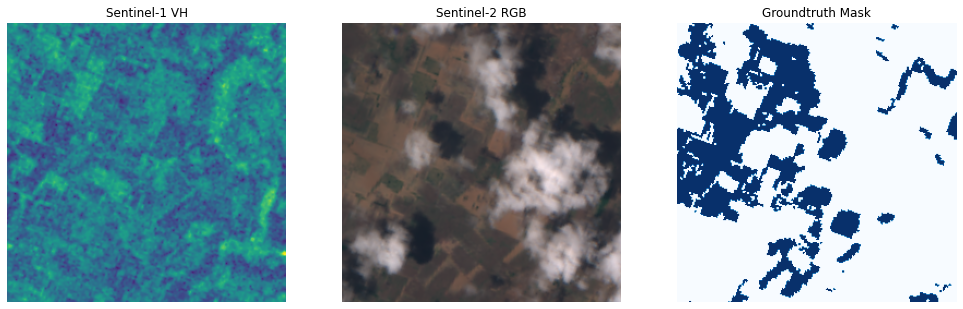

In [4]:
trainset.visualize_observation(8)

/netscratch2/jhanna/chips/val/55d43c77-9955-4b4f-b6f0-b21e7f50a039/s2/S2A_MSIL1C_20190331T170901_N0207_R112_T14TQL_20190331T222948_04096-08704
/netscratch2/jhanna/chips/val/55d43c77-9955-4b4f-b6f0-b21e7f50a039/s1/S1A_IW_GRDH_1SDV_20190404T002124_20190404T002149_026633_02FCE5_A8E7_04096-08704


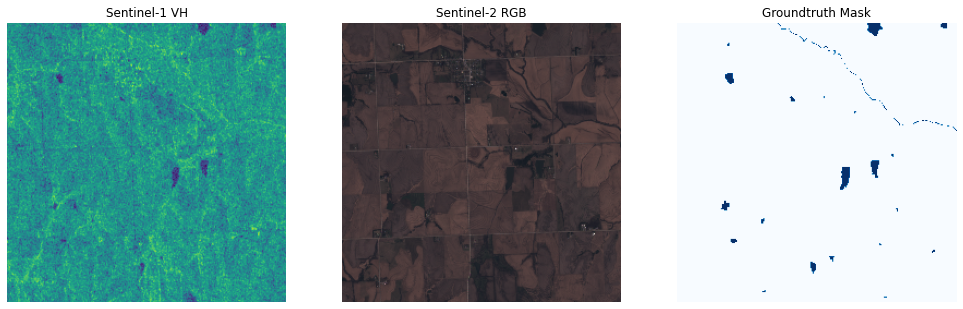

In [6]:
valset.visualize_observation(8)

<a id='model'></a>
## 4. Model Creation

In this lab, we will implement one of the most used neural networks for image segmentation: the U-NET. It is a Fully Convolutional Neural Network Model. This model was initially developed by Olaf Ronneberger, Phillip Fischer, and Thomas Brox in 2015 for medical image segmentation.

The architecture of U-NET is composed of two "paths":

- The first one is the contracting path, also called the encoder. It is used to capture the context of an image. It is in fact a group of convolution layers and max pooling layers allowing to create a feature map of an image and to reduce its size in order to reduce the number of network parameters.

- The second path is the symmetric expanding, also called decoder, to obtain the segmentation mask.

![UNet Model](pictures/unet-model.png)

We will start by defining the different building blocks of this network, namely the downsampling blocks, the upsampling blocks, the double convolution blocks and the output block. 

In [7]:
# Create the convolution block
class DoubleConv(nn.Module):
    """
    The DoubleConv object is composed of two successive blocks of convolutional layers, batch normalization and ReLU.
    """
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels

        # Create a sequential module. 
        # nn.Sequential is a module inside which you can put other modules that will be applied one after the other. 
        self.double_conv = nn.Sequential(
            # First convolutional layer 
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),

            # First batchnormalization
            nn.BatchNorm2d(mid_channels),

            # First ReLU activation function
            nn.ReLU(inplace=True),

            # Second convolutional layer 
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),

            # Second batchnormalization
            nn.BatchNorm2d(out_channels),

            # Second ReLU activation function
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


# Create the downsampling block
class Down(nn.Module):
    """
    The Down object is composed of a maxpooling layer followed by the DoubleConv block defined above.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Create a sequential module. 
        self.maxpool_conv = nn.Sequential(
            # 2D max pooling layer with a kernel size of 2 (meaning spatial dimension will be divided by two)
            nn.MaxPool2d(2),

            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


# Create the upsampling block
class Up(nn.Module):
    """
    The Up object is composed of an upsampling layer (bilinear interpolation) followed by the DoubleConv block defined above.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # upsampling layer with a scale factor of 2 (meaning spatial dimension will be multiplied by two)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
 
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

    
# Create the last convolution block, responsible of the pixel classification
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(UNet, self).__init__()
        
        self.inc = DoubleConv(in_channels, 64)
        
        # Initialise the Encoder
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024 // 2)
        
        # Initialise the Decoder
        self.up1 = Up(1024, 512 // 2)
        self.up2 = Up(512, 256 // 2)
        self.up3 = Up(256, 128 // 2)
        self.up4 = Up(128, 64)
        
        # Last convolution block
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)

        # In these 4 downsampling blocks, the size of the image is gradually reduced
        # while the depth is gradually increased.    
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # In these 4 upsampling  blocks, the size of the image is gradually increased
        # while the depth is gradually reduced.
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        x = self.outc(x)
        return x

In [9]:
model = UNet(13, 1)

<a id='train-val'></a>
## 5. Training and Validation

In [8]:
# First of all, let's verify if a GPU is available on our compute machine. If not, the cpu will be used instead.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print('Device used: {}'.format(device))

Device used: cuda:0


Our UNet model is now ready to be trained. In this section, we will walk through each of the steps in the training loop.

First, we need to define the criterion (the loss function) and the optimizer.

Optimizers define how the neural network weights should be updated. They take the model's parameters and learning rate as input arguments. In this lab, we will use the SGD (Stochastic Gradient Descent) optimizer. There are many other optimizers you can try like Adam, Adagrad, etc. (more info [here](https://pytorch.org/docs/stable/optim.html#algorithms))

In [14]:
# Define a learning rate
learning_rate = 0.01

# Initialise the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

The criterion is the loss you want to minimize. In this lab we will use the BCEWithLogitsLoss(), which is the combination of Sigmoid() and BCELoss(). You can read more about it [here](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

In [10]:
# Initialise the loss function and move it to the GPU if available 
criterion = torch.nn.BCEWithLogitsLoss().to(device)

The steps of a training loop in Pytorch are almost always the same, no matter the application. They are made up of:
- Moving model and data to GPU (if available)
- Making a forward pass through the model
- Calculating the loss with regard to the groundtruth
- Erasing gradients using *optimizer.zero_grad()*
- Calculating the gradients by performing a backward pass using *loss.backward()*
- Updating the weights by taking the optimizer step using *optimizer.step()* 

The steps in a validation loop are similar, but you just need to make a forward pass and calculate the loss. Which means no gradient computation is needed. 

Before implementing this, let's go through 2 modes of the model object in Pytorch:

* Train Mode: Defined by model.train() , it tells your model that you are training the model. Layers like dropout, batchnorm etc. that behave differently in training and testing can behave accordingly.
* Evaluation mode: defined by model.eval() , it tells your model that you are testing the model.


In [13]:
# We will use the tqdm library to display the progress of our training. 
# from tqdm.autonotebook import tqdm
from tqdm import tqdm
from torchmetrics import JaccardIndex

# Move the model to the GPU
model.to(device)

# Create lists for logging losses and evalualtion metrics:
train_losses = []
train_accs = []
train_ious = []

val_losses = []
val_accs = []
val_ious = []

# IoU
jaccard = JaccardIndex(num_classes=2).to(device)


# For every epoch 
for epoch in range(50):
    epoch_loss = 0
    progress = tqdm(
        enumerate(train_loader), desc="Train Loss: ",
        total=len(train_loader)
    )
    
    # Specify you are in training mode
    model.train()
    
    epoch_train_loss = 0
    epoch_val_loss = 0

    epoch_train_ious = 0
    epoch_val_ious = 0

    epoch_train_accs = 0
    epoch_val_accs = 0

    for i, batch in progress:
        # Transfer data to GPU if available
        data = batch["s2_img"].float().to(device)
        label = batch['mask'].float().to(device)
        
        # Make a forward pass
        output = model(data)

        # Derive binary segmentation map from prediction
        output_binary = torch.zeros(output.shape)
        output_binary[output >= 0] = 1

        # Compute IoU
        epoch_train_ious += jaccard(output_binary.to(device), label.int()) / len(train_loader)

        # Compute pixel accuracies
        epoch_train_accs += torch.sum(output_binary.to(device) == label.int()) / (len(train_loader) * (256*256) * 100)
        
        # Compute the loss
        loss = criterion(output, label.unsqueeze(1))
        
        # Clear the gradients
        optimizer.zero_grad()

        # Calculate gradients 
        loss.backward()

        # Update Weights
        optimizer.step()
        
        # Accumulate the loss over the eopch
        epoch_train_loss += loss / len(train_loader)

        progress.set_description("Train Loss: {:.4f}".format(
                                     epoch_train_loss))

    progress = tqdm(
        enumerate(val_loader), desc="val Loss: ",
        total=len(val_loader), position=0, leave=True,)
    
    # Specify you are in evaluation mode
    model.eval()
    
    # Deactivate autograd engine (no backpropagation allowed)
    with torch.no_grad():
        epoch_val_loss = 0
        for j, batch in progress:
            # Transfer Data to GPU if available
            data = batch["s2_img"].float().to(device)
            label = batch['mask'].float().to(device)

            # Make a forward pass
            output = model(data)

            # Derive binary segmentation map from prediction
            output_binary = torch.zeros(output.shape)
            output_binary[output >= 0] = 1

            # Compute IoU
            epoch_val_ious += jaccard(output_binary.to(device), label.int()) / len(val_loader)

            # Compute pixel accuracies
            epoch_val_accs += torch.sum(output_binary.to(device) == label.int()) / (len(val_loader) * (256*256) * 100)
            
            # Compute the loss
            val_loss = criterion(output, label.unsqueeze(1))
                    
            # Accumulate the loss over the epoch
            epoch_val_loss += val_loss / len(val_loader)

            progress.set_description("Validation Loss: {:.4f}".format(
                                     epoch_val_loss))
    if epoch == 0:
        best_val_loss = epoch_val_loss
    else:
        if epoch_val_loss <= best_val_loss:
            best_val_loss = epoch_val_loss
            # Save only the best model
            save_weights_path = "segmentation_model.pth"
            torch.save(model.state_dict(), save_weights_path)

    # Save losses in list, so that we can visualise them later. 
    train_losses.append(epoch_train_loss.cpu().detach().numpy())
    val_losses.append(epoch_val_loss.cpu().detach().numpy())

    # Save IoUs in list, so that we can visualise them later. 
    train_ious.append(epoch_train_ious.cpu().detach().numpy())
    val_ious.append(epoch_val_ious.cpu().detach().numpy())

    # Save accuracies in list, so that we can visualise them later. 
    train_accs.append(epoch_train_accs.cpu().detach().numpy())
    val_accs.append(epoch_val_accs.cpu().detach().numpy())


Validation Loss: 0.0955: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [01:58<00:00,  4.40s/it]


<a id='evaluation'></a>
## 6. Evaluation

Now that the training is done, it is time to visualise the model's progress over the epochs (the losses, the accuracies, the IoUs etc.)

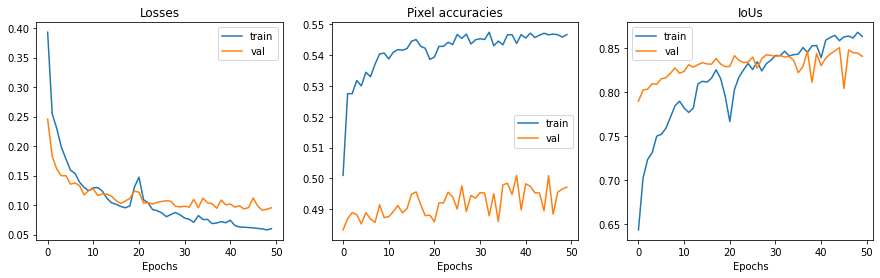

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(train_losses, label='train')
axes[0].plot(val_losses, label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_title('Losses')
axes[0].legend()

axes[1].plot(train_accs, label='train')
axes[1].plot(val_accs, label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_title('Pixel accuracies')
axes[1].legend()

axes[2].plot(train_ious, label='train')
axes[2].plot(val_ious, label='val')
axes[2].set_xlabel('Epochs')
axes[2].set_title('IoUs')
axes[2].legend()

Since there is not enough time during the lab to train properly a model, we will use a pre-trained model (trained on 50 epochs, ~6hours) to qualitatively assess the results.

Let's download and load a pretrained model, and then visualise some predictions

In [ ]:
# Download the Model 
gdown.download('https://drive.google.com/u/1/uc?id=1n-Vtk6G4yegVXPnaT7oJh2QxgoxiD34K&export=download')

In [45]:
# Initialise a UNet() model 
model = UNet(13, 1)
# Load pretrained weights
model.load_state_dict(torch.load('/content/segmentation_model.pth'))
# Move to device (GPU or CPU)
model.to(device);

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, jaccard_score

def get_metrics(true, preds):
    matrix = confusion_matrix(true.flatten(), preds.flatten())
    class_0, class_1 = matrix.diagonal() / matrix.sum(axis=1)
    print('***************** Metrics *****************')
    print('Class 0 (no water) accuracy: {:.3f}'.format(class_0))
    print('Class 1 (water) accuracy: {:.3f}'.format(class_1))
    print('Overall accuracy: {:.3f}'.format(accuracy_score(true.flatten(), preds.flatten())))
    print('Equally Weighted accuracy: {:.3f}'.format(0.5 * class_0 + 0.5 * class_1))
    print('IoU: {:.3f}'.format(jaccard_score(true.flatten(), preds.flatten())))
    print('*******************************************')

In [18]:
def display_outputs(idx=None, multi=False):
    # Pick a random index if none is specified
    if not idx:
        idx = random.randint(0, len(valset))
    print('Validation image ID: {}'.format(idx))
    
    # Get Sentinel 2 and Sentinel 1 data
    s2_data = torch.unsqueeze(valset.__getitem__(idx)['s2_img'].float().to(device), 0)
    s1_data = torch.unsqueeze(valset.__getitem__(idx)['s1_img'].float().to(device), 0)
    
    # Get predictions from the model
    if multi:
        output = model(s1_data, s2_data)
    else:
        output = model(s2_data)
    
    # Threshold the output to generate the binary map (FYI: the threshold value "0" can be tuned as any other hyperparameter)
    output_binary = torch.zeros(output.shape)
    output_binary[output >= 0] = 1
    
    get_metrics(valset.__getitem__(idx)['mask'], output_binary)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    axes[0].imshow(np.transpose(valset.__getitem__(idx)['s2_img'][[3, 2, 1], :, :], (1, 2, 0)) / valset.__getitem__(idx)['s2_img'][[3, 2, 1], :, :].max())
    axes[0].set_title('True Color Sentinel-2')
    axes[2].imshow(valset.__getitem__(idx)['mask'], cmap='Blues')
    axes[2].set_title('Groundtruth')
    axes[1].imshow(output_binary.squeeze(), cmap='Blues')
    axes[1].set_title('Predicted Mask')

Image ID: 73


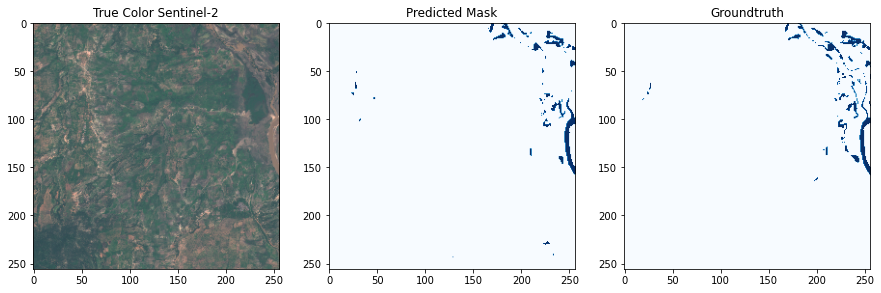

In [56]:
display_outputs()

<a id='multimodal_fusion'></a>
## 7. Multimodal Fusion

So far, we have only considered Sentinel-2 data, and trained a UNet model which performs reasonably. As mentioned earlier, we have access to another type of data, Sentinel-1 images. 



There are different techniques used for multimodal data fusion, we will briefly discuss the three most popular ones.

* **(A) Early Fusion** \
Early Fusion (also known as data-level or input-level fusion) refers to the situation where the two modalities are merged BEFORE they are introduced into the model. The combination can be done in different ways, one example would be to concatenate the two modalities on the channel dimension, another would be to add them etc.

* **(B) Late Fusion** \
Late Fusion (also known as decision-level fusion) refers to the situation where each modality is processed on its own, by seperate networks, and right before the final layer (the decision layer) are merged. The fusion can be done by concatenating feature vectors for example.

* **(C) Intermediate Fusion** \
Intermediate Fusion, as its name suggests, refers to the situation where the two modalities are first processed independently (for example two seperate encoders) and then merged at some point and processed together (using one decoder). 

![Multimodal](pictures/multimodal_fusion.png)

In this lab, we will see how to do Late Fusion, with a DualUNet() model (two UNets, merged before the last output convolution).

First, we will start by creating a UNet model without its last convolution.

In [11]:
class UNet(nn.Module):
    def __init__(self, in_channels):
        super(UNet, self).__init__()

        # Two consecutive Convolution Layers
        self.inc = DoubleConv(in_channels, 64)

        # Encoder initialisation
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024 // 2)
        
        # Decoder initialisation
        self.up1 = Up(1024, 512 // 2)
        self.up2 = Up(512, 256 // 2)
        self.up3 = Up(256, 128 // 2)
        self.up4 = Up(128, 64)

    def forward(self, x):
        x1 = self.inc(x)

        # In these 4 downsampling blocks, the size of the image is gradually reduced
        # while the depth is gradually increased.
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # In these 4 upsampling  blocks, the size of the image is gradually increased
        # while the depth is gradually reduced.
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        return x

Then, we create the DualUNet model, with two UNet streams, as follows:

In [12]:
class DualUNet(nn.Module):
    def __init__(self, in_channels_1, in_channels_2, n_classes):
        super(DualUNet, self).__init__()
        
        # First stream of UNet() for Sentinel 1 data (in_channels_1 = 2)
        self.unet1 = UNet(in_channels_1)
        # Second stream of UNet() for Sentinel 2 data (in_channels_2 = 13)
        self.unet2 = UNet(in_channels_2)
        
        # Output convolution
        self.outc = OutConv(2 * 64, n_classes)

    def forward(self, x1, x2):
        # We process Sentinel1 input
        x1 = self.unet1(x1)
        # We process Sentinel2 input
        x2 = self.unet2(x2)
        
        # We concatenate the two representations
        x = torch.cat([x1, x2], dim=1)
        
        # We feed the fused representation to the output convolution
        x = self.outc(x)
        
        return x

Let's instanciate a DualUNet() model now, with a 2 channels input for Sentinel 1 and 13 channels input for Sentinel 2

In [13]:
model = DualUNet(2, 13, 1)

In [11]:
# Define a learning rate
learning_rate = 0.01

# Initialise the optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# We will use the tqdm library to display the progress of our training. 
# from tqdm.autonotebook import tqdm
from torchmetrics import JaccardIndex
from tqdm import tqdm

# Move the model to the GPU
model.to(device)

# Create lists for logging losses and evalualtion metrics:
train_losses = []
train_accs = []
train_ious = []

val_losses = []
val_accs = []
val_ious = []

jaccard = JaccardIndex(num_classes=2).to(device)

# For every epoch 
for epoch in range(50):
    epoch_loss = 0
    progress = tqdm(
        enumerate(train_loader), desc="Train Loss: ",
        total=len(train_loader)
    )
    
    # Specify you are in training mode
    model.train()
    
    epoch_train_loss = 0
    epoch_val_loss = 0

    epoch_train_ious = 0
    epoch_val_ious = 0

    epoch_train_accs = 0
    epoch_val_accs = 0

    for i, batch in progress:
        # Transfer data to GPU if available
        s2_data = batch["s2_img"].float().to(device)
        s1_data = batch["s1_img"].float().to(device)
        label = batch['mask'].float().to(device)

        # Make a forward pass
        output = model(s1_data, s2_data)

        # Derive binary segmentation map from prediction
        output_binary = torch.zeros(output.shape)
        output_binary[output >= 0] = 1

        # Compute IoU
        epoch_train_ious += jaccard(output_binary.to(device), label.int()) / len(train_loader)

        # Compute pixel accuracies
        epoch_train_accs += torch.sum(output_binary.to(device) == label.int()) / (len(train_loader) * (256*256) * 100)
        
        # Compute the loss
        loss = criterion(output, label.unsqueeze(1))
        
        # Clear the gradients
        optimizer.zero_grad()

        # Calculate gradients 
        loss.backward()

        # Update Weights
        optimizer.step()
        
        # Accumulate the loss over the eopch
        epoch_train_loss += loss / len(train_loader)

        progress.set_description("Train Loss: {:.4f}".format(
                                     epoch_train_loss))


    progress = tqdm(
        enumerate(val_loader), desc="val Loss: ",
        total=len(val_loader)
    )
    
    # Specify you are in evaluation mode
    model.eval()
    
    # Deactivate autograd engine (no backpropagation allowed)
    with torch.no_grad():
        epoch_val_loss = 0
        for i, batch in progress:
            # Transfer data to GPU if available
            s2_data = batch["s2_img"].float().to(device)
            s1_data = batch["s1_img"].float().to(device)
            label = batch['mask'].float().to(device)

            data = torch.cat([s2_data, s1_data], dim=1).to(device)

            # Make a forward pass
            output =  model(s1_data, s2_data)

            # Derive binary segmentation map from prediction
            output_binary = torch.zeros(output.shape)
            output_binary[output >= 0] = 1

            # Compute IoU
            epoch_val_ious += jaccard(output_binary.to(device), label.int()) / len(val_loader)

            # Compute pixel accuracies
            epoch_val_accs += torch.sum(output_binary.to(device) == label.int()) / (len(val_loader) * (256*256) * 100)
            
            # Compute the loss
            val_loss = criterion(output, label.unsqueeze(1))

            # Accumulate the loss over the epoch
            epoch_val_loss += val_loss / len(val_loader)

            progress.set_description("Validation Loss: {:.4f}".format(
                                     epoch_val_loss))
    if epoch == 0:
        best_val_loss = epoch_val_loss
    else:
        if epoch_val_loss <= best_val_loss:
            best_val_loss = epoch_val_loss
            # Save model
            save_weights_path = "segmentation_model_late_fusion.pth"
            torch.save(model.state_dict(), save_weights_path)

    # Save losses in list, so that we can visualise them later. 
    train_losses.append(epoch_train_loss.cpu().detach().numpy())
    val_losses.append(epoch_val_loss.cpu().detach().numpy())

    # Save IoUs in list, so that we can visualise them later. 
    train_ious.append(epoch_train_ious.cpu().detach().numpy())
    val_ious.append(epoch_val_ious.cpu().detach().numpy())

    # Save accuracies in list, so that we can visualise them later. 
    train_accs.append(epoch_train_accs.cpu().detach().numpy())
    val_accs.append(epoch_val_accs.cpu().detach().numpy())

Train Loss: 0.0021:   3%|█████████▏                                                                                                                                                                                                                                                            | 3/86 [00:14<06:51,  4.96s/it]

Same as before, since there is not enough time during the lab to train properly a model, we will use a pre-trained model (trained on 50 epochs, ~7hours) to qualitatively assess the results.

Let's download and load a pretrained model, and then visualise some predictions

In [ ]:
# Download the Model 
gdown.download('https://drive.google.com/u/1/uc?id=1W5pr_2RnEF5FDFDNg_0-U2wQzO4DEw86&export=download')

In [21]:
model = DualUNet(2, 13, 1)

# Load pretrained weights
model.load_state_dict(torch.load('segmentation_model_late_fusion.pth'))
# Move to device (GPU or CPU)
model.to(device);

Validation image ID: 62


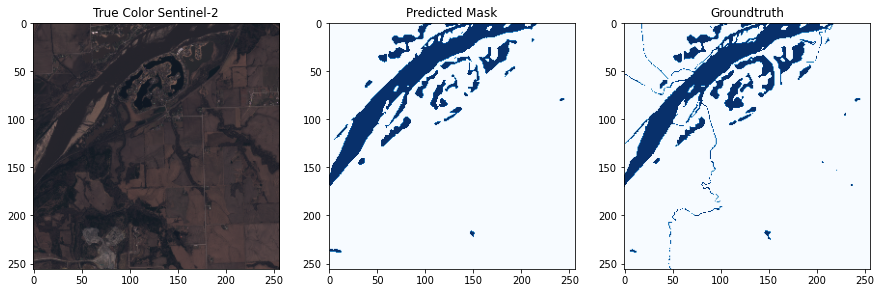

In [19]:
display_outputs(multi=True)

Validation image ID: 33


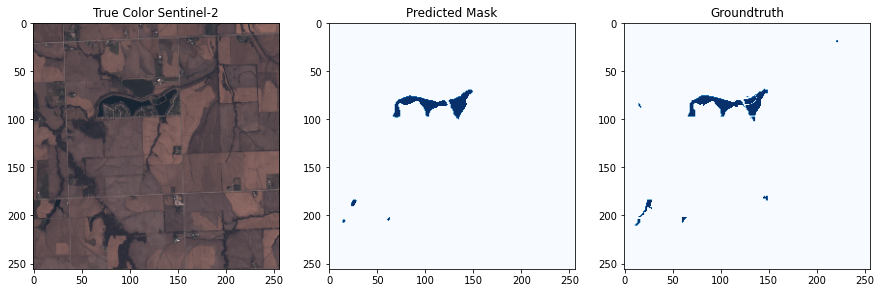

In [46]:
display_outputs(multi=True)

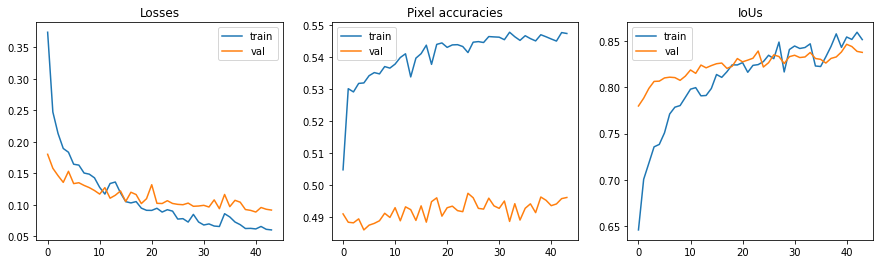

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(train_losses, label='train')
axes[0].plot(val_losses, label='val')
axes[0].set_title('Losses')
axes[0].legend()

axes[1].plot(train_accs, label='train')
axes[1].plot(val_accs, label='val')
axes[1].set_title('Pixel accuracies')
axes[1].legend()

axes[2].plot(train_ious, label='train')
axes[2].plot(val_ious, label='val')
axes[2].set_title('IoUs')
axes[2].legend()

<a id='exercice'></a>
## 8. Exercice

As an exercise, try implementing another type of modality fusion (e.g. early fusion or, for the more motivated, intermediate fusion) and see how it compares to the late fusion we just implemented.

<a id='conclusion'></a>
## 9. Conclusion

In this lab, we have seen how to perform water segmentation, with the aim of detecting floods. We used data from Sentinel-1 and Sentinel-2 satellites, and also saw how to merge different modalities, in order to enrich the input. 

There are several future directions for improving initial performance. Some ideas include:
* An improvement of the architecture of the model (why not try using transformers?)
* A different approach based on change detection (input *before* and *after* images)
* Taking advantage of the time-serie nature of the data
* Do an ablation study on the 13 channels of Sentinel-2 input - infrared and SWIR bands might be the most informative ones for water detection ... 

<a id='references'></a>
## 10. References

[UNet Model](https://github.com/milesial/Pytorch-UNet)